# **Generate CT Images with CycleGAN**



<p align="center">
    <img src="https://static.vecteezy.com/system/resources/thumbnails/004/640/933/small_2x/cycle-arrow-illustration-on-white-background-creative-icon-vector.jpg" height=400 width=1000 alt="Ultralytics">
</p>

<small>Picture Source: <a href="https://static.vecteezy.com/">vecteezy</a></small>





## **0.0 CycleGAN Overview**

CycleGAN, or Cycle-Consistent Generative Adversarial Network, is a sophisticated generative model specifically designed for unpaired image-to-image translation tasks. Unlike traditional approaches that require matched image pairs from two different domains—such as images of CT images This capability is particularly valuable in scenarios where obtaining paired data is impractical or impossible. For instance, in medical applications, it may be challenging to find corresponding images of intact and CT images. CycleGAN addresses this by leveraging a dual-generative architecture and enforcing cycle consistency, ensuring that the transformations maintain the underlying content and semantic structure of the images. This allows for more flexible and creative applications in various fields, including art, style transfer, and domain adaptation, where the relationships between the source and target images can be complex and non-linear.

<br>

**Key Components:**

1. **Two Generators**:
   - **$G$**: Transforms images from domain X  to domain $Y$ .
   - **$F$**: Transforms images from domain $Y$ back to domain $X$.

2. **Two Discriminators**:
   - **$D_Y$**: Distinguishes between real images from domain Y and generated images from $G$.
   - **$D_X$**: Distinguishes between real images from domain X and generated images from $F$.

3. **Cycle Consistency Loss**:
   - Ensures that if you translate an image from $X$ to $Y$ and then back to $X$ (or vice versa), you should end up with the original image. This helps maintain content and style integrity during translation.

4. **Adversarial Loss**:
   - Similar to other GANs, CycleGAN employs adversarial loss to encourage the generators to produce realistic images that can fool the discriminators.

<br>

**Applications:**

CycleGAN has been effectively used in various applications, including:
- Style transfer
- Image synthesis
- Domain adaptation

<br>

This makes it a powerful tool for creative and practical image manipulation tasks. **I just want to special thank to [Sharon Zhou](https://scholar.google.co.uk/citations?user=Kn35TAQAAAAJ&hl=en).**

## **1.0. Goals**

In this notebook, you will write a generative model based on the paper [*Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks*](https://arxiv.org/abs/1703.10593) by Zhu et al. 2017, commonly referred to as **CycleGAN**. The focus of this assignment is to train a model capable of transforming images of buildings into images of collapsed structures, and vice versa. Special emphasis will be placed on the implementation of the loss functions. To expedite the process and achieve quality outputs, you will begin training from a pre-trained checkpoint. However, you also have the option to train the model from scratch if you prefer.


## **2.0. Getting Started**
You will start by importing libraries, defining a visualization function, and getting the pre-trained CycleGAN checkpoint.

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
!unzip -q /content/ct.zip

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')  # Grayscale
        item_B = Image.open(self.files_B[self.randperm[index]]).convert('L')  # Grayscale

        item_A = self.transform(item_A)
        item_B = self.transform(item_B)

        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

## **3.0. Generator**
The code for a CycleGAN generator is much like Pix2Pix's U-Net with the addition of the residual block between the encoding (contracting) and decoding (expanding) blocks.

#### **3.1. Residual Block**

Perhaps the most notable architectural difference between the U-Net used in Pix2Pix and the architecture employed in CycleGAN is the incorporation of residual blocks. In CycleGAN, following the expanding blocks, there are convolutional layers where the output is added back to the original input. This design allows the network to modify the image as little as possible, preserving essential features during the transformation.

In [ ]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class:
    Performs two convolutions and an instance normalization, the input is added
    to this output to form the residual block output.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ResidualBlock:
        Given an image tensor, completes a residual block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

#### **3.2. Contracting and Expanding Blocks**

The rest of the generator code will otherwise be much like the code you wrote for the last assignment: Pix2Pix's U-Net. The primary changes are the use of instance norm instead of batch norm (which you may recall from StyleGAN), no dropout, and a stride-2 convolution instead of max pooling. Feel free to investigate the code if you're interested!

In [ ]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs a convolution followed by a max pool operation and an optional instance norm.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock:
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs a convolutional transpose operation in order to upsample,
        with an optional instance norm
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ExpandingBlock:
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a Generator -
    maps each the output to the desired number of output channels
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock:
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

#### **3.3. CycleGAN Generator**
Finally, you can put all the blocks together to create your CycleGAN generator.

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    A series of 2 contracting blocks, 9 residual blocks, and 2 expanding blocks to
    transform an input image into an image from the other class, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''
        Function for completing a forward pass of Generator:
        Given an image tensor, passes it through the U-Net with residual blocks
        and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## **4. PatchGAN Discriminator**

Next, you will define the discriminator—a PatchGAN. It will be very similar to what you saw in Pix2Pix.

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake.
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

## **5. Training Preparation**

Now you can put everything together for training! You will start by defining your parameters:

  *   `adv_criterion`: an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
  *   `recon_criterion`: a loss function that rewards similar images to the ground truth, which "reconstruct" the image
  *   `n_epochs`: the number of times you iterate through the entire dataset when training
  *   `dim_A`: the number of channels of the images in pile A
  *   `dim_B`: the number of channels of the images in pile B (note that in the visualization this is currently treated as equivalent to dim_A)
  *   `display_step`: how often to display/visualize the images
  *   `batch_size`: the number of images per forward/backward pass
  *   `lr`: the learning rate
  *   target_shape: the size of the input and output images (in pixels)
  *   `load_shape`: the size for the dataset to load the images at before randomly cropping them to `target_shape` as a simple data augmentation
  *   `device`: the device type

In [ ]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

In [ ]:
n_epochs = 20  # @param {type: "number"}
dim_A = 1  # @param {type: "number"}
dim_B = 1  # @param {type: "number"}
display_step = 200  # @param {type: "number"}
batch_size = 1  # @param {type: "number"}
lr = 0.0002  # @param {type: "number"}
load_shape = 512  # @param {type: "number"}
target_shape = 512  # @param {type: "number"}
device = 'cuda'  # @param {type: "string"}

You will then load the images of the dataset while introducing some data augmentation (e.g. crops and random horizontal flips).

In [ ]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("ct", transform=transform)

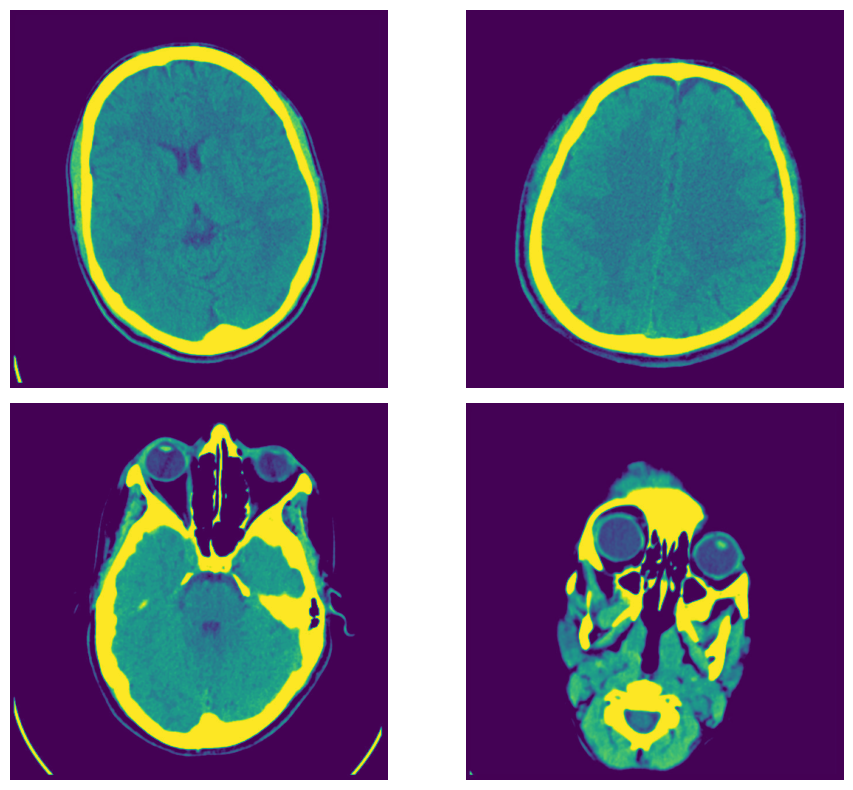

In [ ]:
num_images = 4

fig, axes = plt.subplots(nrows=num_images // 2, ncols=2, figsize=(10, num_images * 2))
axes = axes.flatten()

for i in range(num_images):
    image, label = dataset[i]
    image = image.numpy().transpose(1, 2, 0)

    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Next, you can initialize your generators and discriminators, as well as their optimizers. For CycleGAN, you will have two generators and two discriminators since there are two GANs:

* Generator for building to collapsed building: `gen_AB`
* Generator for collapsed building to building: `gen_BA`
* Discriminator for building: `disc_A`
* Discriminator for collapsed building: `disc_B`

You will also load your pre-trained model.

In [ ]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
# Change pretrained to False if you're training the model from scratch.
pretrained = False
if pretrained:
    pre_dict = torch.load('cycleGAN_100000.pth')
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)

## **6. Discriminator Loss**
First, you're going to be implementing the discriminator loss. This is the same as in previous assignments, so it should be a breeze :) Don't forget to detach your generator!

In [ ]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator
            predictions and the target labels and returns a adversarial
            loss (which you aim to minimize)
    '''
    disc_fake_X_hat = disc_X(fake_X.detach())
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    return disc_loss

## **7. Generator Loss**
While there are some changes to the CycleGAN architecture from Pix2Pix, the most important distinguishing feature of CycleGAN is its generator loss. You will be implementing that here!

### **7.1. Adversarial Loss**
The first component of the generator's loss you're going to implement is its adversarial loss—this once again is pretty similar to the GAN loss that you've implemented in the past. The important thing to note is that the criterion now is based on least squares loss, rather than binary cross entropy loss or W-loss.

In [ ]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator
                  predictions and the target labels and returns a adversarial
                  loss (which you aim to minimize)
    '''
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    return adversarial_loss, fake_Y

### **7.2. Identity Loss**

In this section, you'll explore an important aspect of CycleGAN. Specifically, you will measure the change in an image when you input an example from the target domain into the generator that expects the source domain. The output should ideally match the input, as it is already of the target domain class.

In [ ]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Return the identity loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        gen_YX: the generator for class Y to X; takes images and returns the images
            transformed to class X
        identity_criterion: the identity loss function; takes the real images from X and
                        those images put through a Y->X generator and returns the identity
                        loss (which you aim to minimize)
    '''
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    return identity_loss, identity_X

### **7.3. Cycle Consistency Loss**

Now, you can implement the final generator loss and the part that puts the "cycle" in CycleGAN: cycle consistency loss. This is used to ensure that when you put an image through one generator, that if it is then transformed back into the input class using the opposite generator, the image is the same as the original input image.

Since you've already generated a fake image for the adversarial part, you can pass that fake image back to produce a full cycle—this loss will encourage the cycle to preserve as much information as possible.

In [ ]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    return cycle_loss, cycle_X

### **7.4. Generator Loss (Total)**

Finally, you can put it all together! There are many components, so be careful as you go through this section.

In [ ]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        real_A: the real images from pile A
        real_B: the real images from pile B
        gen_AB: the generator for class A to B; takes images and returns the images
            transformed to class B
        gen_BA: the generator for class B to A; takes images and returns the images
            transformed to class A
        disc_A: the discriminator for class A; takes images and returns real/fake class A
            prediction matrices
        disc_B: the discriminator for class B; takes images and returns real/fake class B
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator
            predictions and the true labels and returns a adversarial
            loss (which you aim to minimize)
        identity_criterion: the reconstruction loss function used for identity loss
            and cycle consistency loss; takes two sets of images and returns
            their pixel differences (which you aim to minimize)
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
            those images put through a X->Y generator and then Y->X generator
            and returns the cycle consistency loss (which you aim to minimize).
            Note that in practice, cycle_criterion == identity_criterion == L1 loss
        lambda_identity: the weight of the identity loss
        lambda_cycle: the weight of the cycle-consistency loss
    '''

    # Adversarial Loss
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss

    return gen_loss, fake_A, fake_B

## **8. CycleGAN Training**

In [ ]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)

In [ ]:
def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):

        for real_A, real_B in tqdm(dataloader):

            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            disc_A_opt.step()

            disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)
            disc_B_opt.step()

            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            gen_opt.step()

            mean_discriminator_loss += disc_A_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step

            # Visualization code
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0

                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")
            cur_step += 1


  0%|          | 0/1742 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.09232728958129882, Discriminator loss: 0.003515838384628296


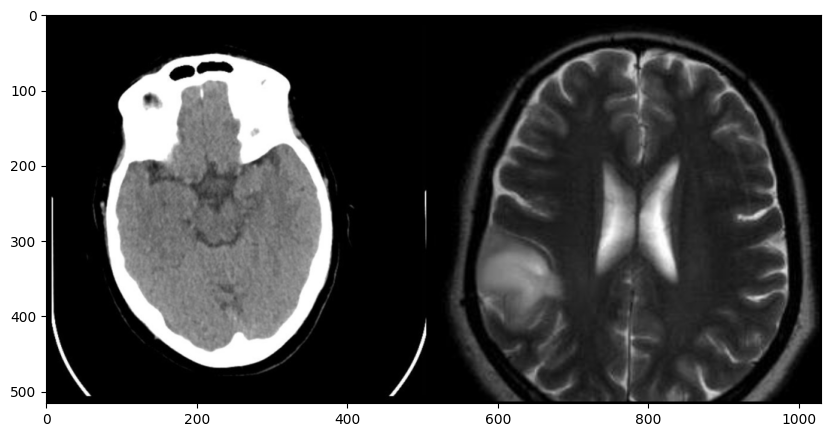

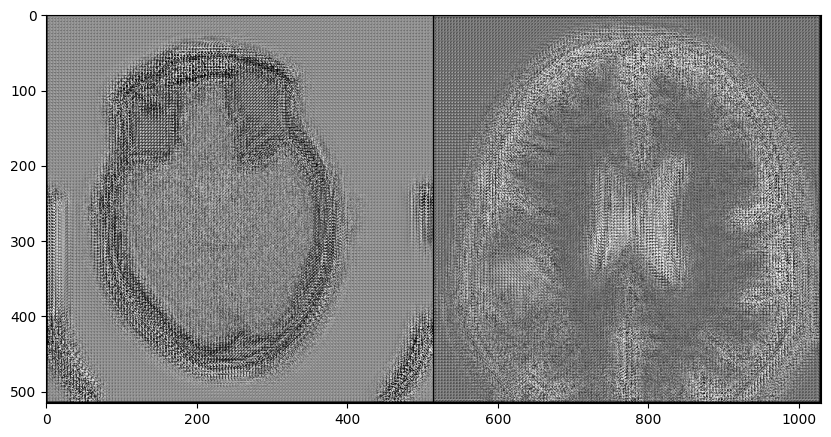

Epoch 0: Step 200: Generator (U-Net) loss: 4.426596988439561, Discriminator loss: 0.2115635530278086


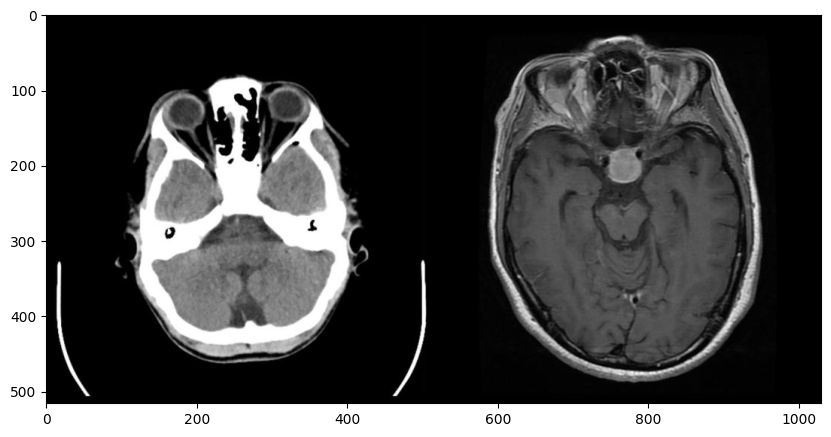

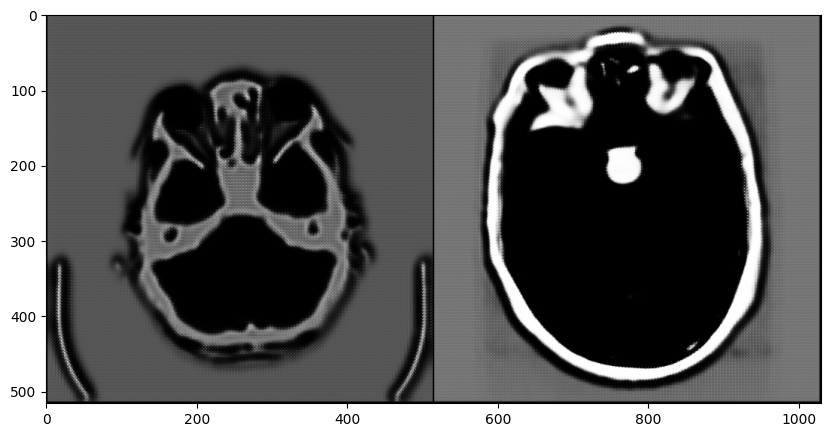

Epoch 0: Step 400: Generator (U-Net) loss: 4.213556866645814, Discriminator loss: 0.17285571895539767


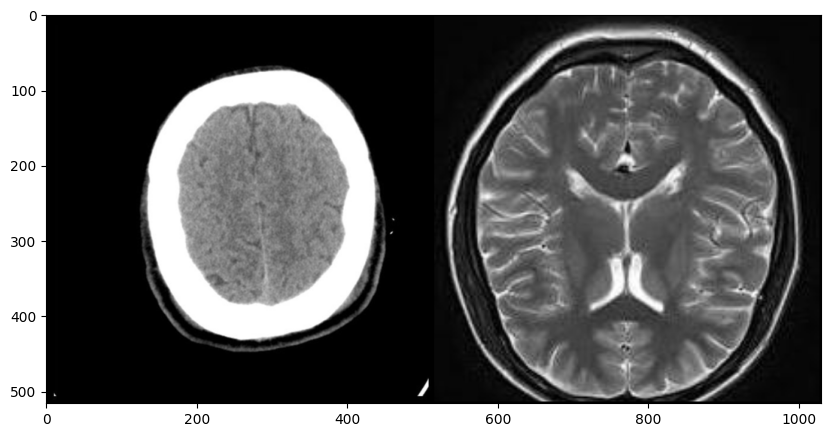

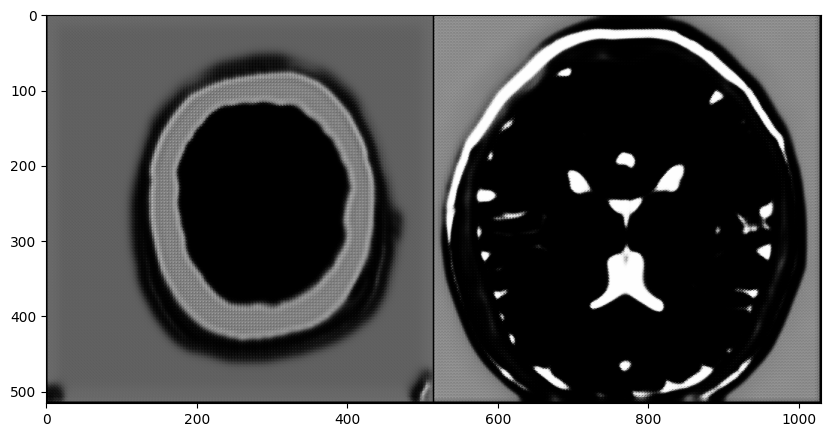

KeyboardInterrupt: 

In [ ]:
train(save_model=True)